# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [24]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [26]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.434189
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Because we are using an almost-zero weight matrix, we would expect the classifier to be assigning almost the same scores for each class. Therefore the inner term, despite the exponentiation, becomes approximately 1/C, which is 1/10 in our case, as e^x for small x in the mathematical sense, is approximately equal to 1. The rest of the expression follows from the definition of softmax loss.


In [27]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.350466 analytic: -0.350466, relative error: 2.205739e-07
numerical: 3.359288 analytic: 3.359288, relative error: 2.353834e-08
numerical: -2.352535 analytic: -2.352536, relative error: 1.622056e-08
numerical: 1.572574 analytic: 1.572574, relative error: 3.069202e-08
numerical: -4.158446 analytic: -4.158445, relative error: 1.059627e-08
numerical: -1.464390 analytic: -1.464390, relative error: 6.902462e-09
numerical: -2.840014 analytic: -2.840014, relative error: 6.055564e-09
numerical: 0.365258 analytic: 0.365258, relative error: 1.382189e-07
numerical: -0.005162 analytic: -0.005162, relative error: 1.206640e-06
numerical: -1.120940 analytic: -1.120940, relative error: 1.082178e-08
numerical: 3.784398 analytic: 3.784398, relative error: 1.004436e-08
numerical: 0.180572 analytic: 0.180572, relative error: 1.672179e-08
numerical: -0.518505 analytic: -0.518505, relative error: 6.596282e-08
numerical: 3.022049 analytic: 3.022049, relative error: 1.934151e-08
numerical: -3.0749

In [28]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.434189e+00 computed in 0.165533s
vectorized loss: 2.434189e+00 computed in 0.013488s
Loss difference: 0.000000
Gradient difference: 0.000000


In [47]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 1e-6]
regularization_strengths = [1e3, 4.5e3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
NUM_TRIALS = 50
NUM_ITERS = 3000

# Sample dimensions individually
learning_rate_samples = np.exp(np.random.uniform(
                            np.log(learning_rates[0]), 
                            np.log(learning_rates[1]),
                            NUM_TRIALS
                        ))
regularization_strength_samples = np.exp(np.random.uniform(
                            np.log(regularization_strengths[0]),
                            np.log(regularization_strengths[1]),
                            NUM_TRIALS
                        ))
# Zip together
samples = np.array([learning_rate_samples, regularization_strength_samples]).T

for i in xrange(NUM_TRIALS):
    print("Trial " + str(i))
    learning_rate = learning_rate_samples[i]
    reg_strength = regularization_strength_samples[i]
    
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, 
                          reg=reg_strength, num_iters=NUM_ITERS, verbose=True)
    y_train_pred = softmax.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    
    results[(learning_rate, reg_strength)] = (training_accuracy, validation_accuracy)

    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


Trial 0
iteration 0 / 3000: loss 65.029154
iteration 100 / 3000: loss 55.308060
iteration 200 / 3000: loss 48.720464
iteration 300 / 3000: loss 43.233949
iteration 400 / 3000: loss 38.032245
iteration 500 / 3000: loss 33.733989
iteration 600 / 3000: loss 30.263202
iteration 700 / 3000: loss 26.468796
iteration 800 / 3000: loss 23.915074
iteration 900 / 3000: loss 21.338464
iteration 1000 / 3000: loss 18.961717
iteration 1100 / 3000: loss 16.966270
iteration 1200 / 3000: loss 15.153039
iteration 1300 / 3000: loss 13.649724
iteration 1400 / 3000: loss 12.216127
iteration 1500 / 3000: loss 10.951774
iteration 1600 / 3000: loss 9.946193
iteration 1700 / 3000: loss 8.998455
iteration 1800 / 3000: loss 8.147607
iteration 1900 / 3000: loss 7.403538
iteration 2000 / 3000: loss 6.779062
iteration 2100 / 3000: loss 6.137567
iteration 2200 / 3000: loss 5.765404
iteration 2300 / 3000: loss 5.234081
iteration 2400 / 3000: loss 4.758888
iteration 2500 / 3000: loss 4.439803
iteration 2600 / 3000: los

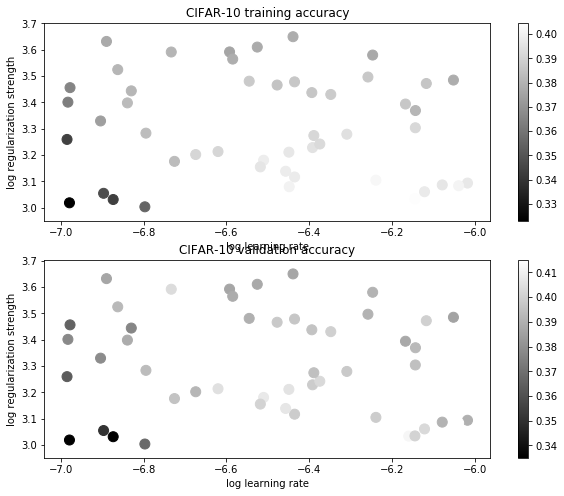

In [48]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [49]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.384000


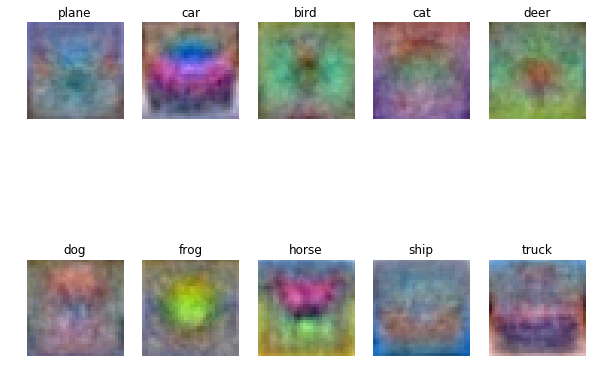

In [50]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])